# Using PauliPropagation.jl from Python via JuliaCall

This notebook demonstrates how to leverage the functionalities of the Julia package `PauliPropagation.jl` directly within a Python environment. We achieve this using the `juliacall` library, which acts as a bridge between Python and Julia.

**Goals:**
*   Show how to install and set up `juliacall`.
*   Replicate the "Basic Example" from `PauliPropagation.jl` using Python.
*   Illustrate data type conversions and calling Julia functions.
*   Provide examples of more advanced usage, such as efficient layer-wise evolution and truncation settings comparison.

In [9]:
# Install juliacall if you haven't already
# Uncomment the following line to install
#!pip install juliacall

### 2. Initializing Julia and `PauliPropagation.jl`

This cell performs the following crucial setup steps:
1.  **Imports `juliacall`**: It imports the `Main` object from `juliacall` and aliases it as `jl`. This `jl` object will be our primary interface to Julia.
2.  **Prints Julia Version**: It accesses and prints the version of the underlying Julia interpreter that `juliacall` is using.
3.  **Installs `PauliPropagation.jl`**: It uses `jl.seval()` to execute a Julia code block. This block checks if `PauliPropagation.jl` is already part of the current Julia project's dependencies. If not, it adds the package from the official Julia registry. This ensures the package is available for use.
4.  **Imports `PauliPropagation.jl` in Julia**: Finally, it executes `using PauliPropagation` within the Julia environment, making all exported functions and types from the package available through `jl.PauliPropagation`.

In [10]:
from juliacall import Main as jl

print("Julia version:", jl.VERSION)

# Install PauliPropagation if not already installed
# Note: This might take a while the first time
jl.seval("""
    using Pkg
    if !haskey(Pkg.project().dependencies, "PauliPropagation")
        Pkg.add("PauliPropagation")  # Install from registered package
    end
""")

jl.seval("using PauliPropagation")

Julia version: 1.10.9


### 2.1 Creating Aliases for Easier Access to Julia Functions

To make working with Julia functions more concise in Python, we'll create aliases for commonly used functions. This cell demonstrates two approaches:
1. **Module-level alias**: Creating a shorter name (`pp`) for the `PauliPropagation` module.
2. **Function-level aliases**: Exposing specific Julia functions directly to the Python namespace.
3. **Symbol constants**: Creating Python variables for Julia `Symbol`s representing Pauli operators.

These aliases will make subsequent code more readable while maintaining access to Julia's functionality.

In [11]:
pp = jl.PauliPropagation

# Import specific functions into the Python namespace
jl.seval("""
    # Make commonly used functions directly accessible
    paulisum = PauliPropagation.PauliSum
    paulistring = PauliPropagation.PauliString
    bricklayer = PauliPropagation.bricklayertopology
    propagate = PauliPropagation.propagate
    overlapzero = PauliPropagation.overlapwithzero
    countparams = PauliPropagation.countparameters
    tiltedtfitrotter = PauliPropagation.tiltedtfitrottercircuit
""")

# Create Symbol constants for Pauli operators
Xsym = jl.Symbol("X")
Ysym = jl.Symbol("Y")
Zsym = jl.Symbol("Z")
Isym = jl.Symbol("I")

print("PauliPropagation.jl module aliased as 'pp'")
print("Key functions also imported directly into Julia Main")
print("Created Python variables for Pauli operator Symbols: Xsym, Ysym, Zsym, Isym")

PauliPropagation.jl module aliased as 'pp'
Key functions also imported directly into Julia Main
Created Python variables for Pauli operator Symbols: Xsym, Ysym, Zsym, Isym


### 3. Basic Example: Propagating a Pauli Observable with Tilted TFIM Circuit

This cell replicates the core "Basic Example" from the `PauliPropagation.jl` documentation, demonstrating the fundamental workflow:

1.  **Define System Size (`nqubits`)**: Sets the number of qubits in the quantum system.
2.  **Create Observable**: Defines a `PauliString` observable using `pp.PauliString` and our `Zsym` for cleaner code.
3.  **Define Circuit Topology**: Creates a `bricklayertopology` for the quantum circuit, which specifies how gates are arranged.
4.  **Create Quantum Circuit**: Defines a Tilted Transverse Field Ising Model (TFIM) Trotter circuit.
5.  **Set Circuit Parameters**: Creates a Julia array filled with parameters.
6.  **Propagate Observable**: Evolves the `observable` through the `circuit` with the given `parameters`.
7.  **Calculate Overlap**: Computes the expectation value of the propagated `PauliSum`.
8.  **Print Results**: Outputs key information about the process and result.

In [12]:
# Smaller system size for faster execution
nqubits = 10

# Using our "pp" alias and Zsym for cleaner code
observable = pp.PauliString(nqubits, Zsym, nqubits // 2)
print("Observable:", observable)

topology = pp.bricklayertopology(nqubits, periodic=True)
print("Topology type:", type(topology))

# Using tilted TFIM circuit for a more non-trivial example
nlayers = 5
circuit = pp.tiltedtfitrottercircuit(nqubits, nlayers, topology=topology)
print(f"Circuit has {pp.countparameters(circuit)} parameters")

dt = 0.1
parameters = jl.fill(dt, pp.countparameters(circuit))

max_weight = 6
min_abs_coeff = 1e-4
pauli_sum = pp.propagate(
    circuit, observable, parameters,
    max_weight=max_weight, min_abs_coeff=min_abs_coeff
)
print(f"Result has {jl.length(pauli_sum)} Pauli terms")

overlap = pp.overlapwithzero(pauli_sum)
print(f"Overlap with |0⟩⊗n: {overlap}")

Observable: PauliString(nqubits: 10, 1.0 * IIIIZIIIII)
Topology type: <class 'juliacall.VectorValue'>
Circuit has 150 parameters
Result has 50 Pauli terms
Overlap with |0⟩⊗n: 0.8974214739570514


### 4. Working with Julia Data Types and Functions from Python

This cell showcases several ways to interact with Julia's data types and functionalities from Python:

1.  **Convert Julia Array to Python NumPy Array**:
    *   `jl.rand(10)`: Creates a Julia array of 10 random numbers.
    *   `np.array(julia_array)`: Converts this Julia array into a Python NumPy array.
    *   The types of both arrays are printed to demonstrate the conversion.
2.  **Define and Call a Custom Julia Function**:
    *   `jl.seval("""...""")`: Defines a new Julia function named `count_nonzero_terms` directly within the Julia runtime. This function takes a `pauli_sum` (expected to be a `PauliSum` object) and returns the number of terms in it using `length(pauli_sum)`.
    *   `jl.count_nonzero_terms(pauli_sum)`: Calls this newly defined Julia function from Python, passing the `pauli_sum` object obtained from the previous propagation.
    *   The result is converted to a Python `int` and printed.
3.  **Access Julia Documentation**:
    *   `jl.seval("@doc PauliPropagation.propagate")`: Executes Julia's macro `@doc` to retrieve the documentation string for the `PauliPropagation.propagate` function.
    *   The fetched documentation text is printed.

In [13]:
import numpy as np
import matplotlib.pyplot as plt

julia_array = jl.rand(10)
python_array = np.array(julia_array)
print("Julia array type:", type(julia_array))
print("Python array type:", type(python_array))
print("Python array content:", python_array)

jl.seval("""
function count_nonzero_terms(pauli_sum)
    return length(pauli_sum)
end
""")

num_terms = jl.count_nonzero_terms(pauli_sum)
print(f"Number of non-zero Pauli terms: {int(num_terms)}")

help_text = jl.seval("@doc PauliPropagation.propagate")
print("Documentation for propagate function:")
print(help_text)

Julia array type: <class 'juliacall.VectorValue'>
Python array type: <class 'numpy.ndarray'>
Python array content: [0.59156653 0.45452893 0.89582397 0.20504427 0.71872016 0.68849901
 0.30996218 0.00820657 0.72276768 0.79759287]
Number of non-zero Pauli terms: 50
Documentation for propagate function:
```
propagate(circ, pstr::PauliString, thetas=nothing; max_weight=Inf, min_abs_coeff=1e-10, max_freq=Inf, max_sins=Inf, customtruncfunc=nothing, kwargs...)
```

Propagate a `PauliString` through the circuit `circ` in the Heisenberg picture.  This means that the circuit is applied to the Pauli string in reverse order, and the action of each gate is its conjugate action. Parameters for the parametrized gates in `circ` are given by `thetas`, and need to be passed as if the circuit was applied as written in the Schrödinger picture. If thetas are not passed, the circuit must contain only non-parametrized `StaticGates`. Default truncations are `max_weight`, `min_abs_coeff`, `max_freq`, and `max_s

### 5. Efficient Layer-wise Evolution of an Observable

This example demonstrates a physically meaningful and efficient approach to visualize how an observable evolves as the circuit depth increases:

1. Create a **single-layer** tilted TFIM circuit.
2. Start with the initial observable as a `PauliSum`.
3. Repeatedly propagate the same observable through the single layer, one at a time.
4. Track the expectation value after each layer.

This approach is much more efficient than creating a new circuit for each depth and is more realistic for studying quantum dynamics.

Visualizing efficient layer-wise evolution...
Layer 0, Overlap: 1.0, Terms: 1
Layer 1, Overlap: 1.0, Terms: 1
Layer 5, Overlap: 1.0, Terms: 1
Layer 10, Overlap: 1.0, Terms: 1
Layer 15, Overlap: 1.0, Terms: 1
Layer 20, Overlap: 1.0, Terms: 1


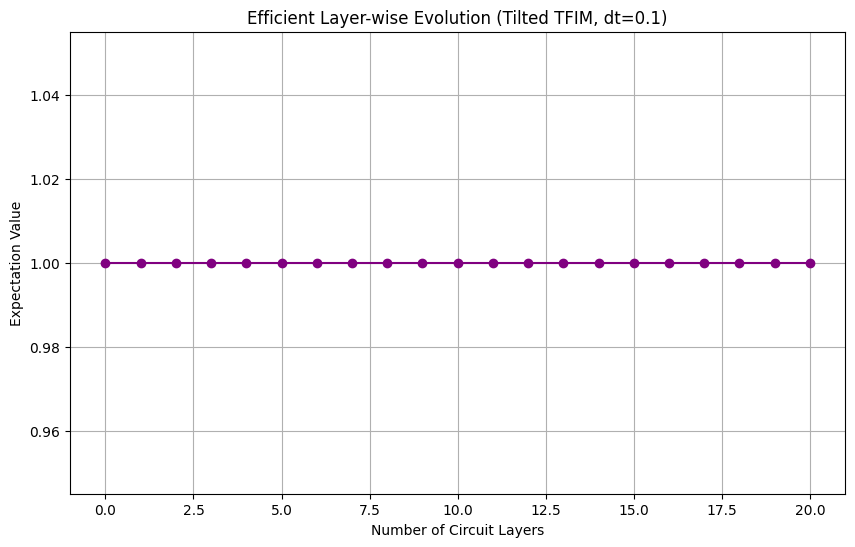

In [14]:
print("Visualizing efficient layer-wise evolution...")

# Parameters for this example
dt = 0.1
max_layers = 20

# A single-layer tilted TFIM circuit
single_layer = pp.tiltedtfitrottercircuit(nqubits, 1, topology=topology)
layer_params = jl.fill(dt, pp.countparameters(single_layer))

psum = pp.PauliSum(observable)

layer_indices = list(range(0, max_layers + 1))
expectation_values = [float(pp.overlapwithzero(psum))]
print(f"Layer 0, Overlap: {expectation_values[0]}, Terms: {int(jl.length(psum))}")

# Apply layers incrementally
for l in range(1, max_layers + 1):
    pp.propagate(
        single_layer, psum, layer_params,
        max_weight=max_weight, min_abs_coeff=min_abs_coeff
    )
    # Calculate new expectation value
    overlap = float(pp.overlapwithzero(psum))
    expectation_values.append(overlap)
    if l % 5 == 0 or l == 1:  # Print every 5 layers and the first layer
        print(f"Layer {l}, Overlap: {overlap}, Terms: {int(jl.length(psum))}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(layer_indices, expectation_values, 'o-', color='purple')
plt.xlabel('Number of Circuit Layers')
plt.ylabel('Expectation Value')
plt.title(f'Efficient Layer-wise Evolution (Tilted TFIM, dt={dt})')
plt.grid(True)
plt.show()

### 6. Comparing Truncation Effects on Efficient Layer-wise Evolution

This section combines the efficient layer-wise evolution with different truncation settings to visualize the trade-off between accuracy and computational efficiency:

1. For each `max_weight` setting:
   * Initialize a fresh `PauliSum` from the observable.
   * Apply the single-layer circuit repeatedly, using the current truncation setting.
   * Track the growth of Pauli terms to observe the computational complexity.
   * Plot the expectation value evolution.

By comparing the different curves, we can see how aggressive truncation affects accuracy.

Max weight 2: 1 Pauli terms after 20 layers
Max weight 4: 1 Pauli terms after 20 layers
Max weight 6: 1 Pauli terms after 20 layers
Max weight 8: 1 Pauli terms after 20 layers


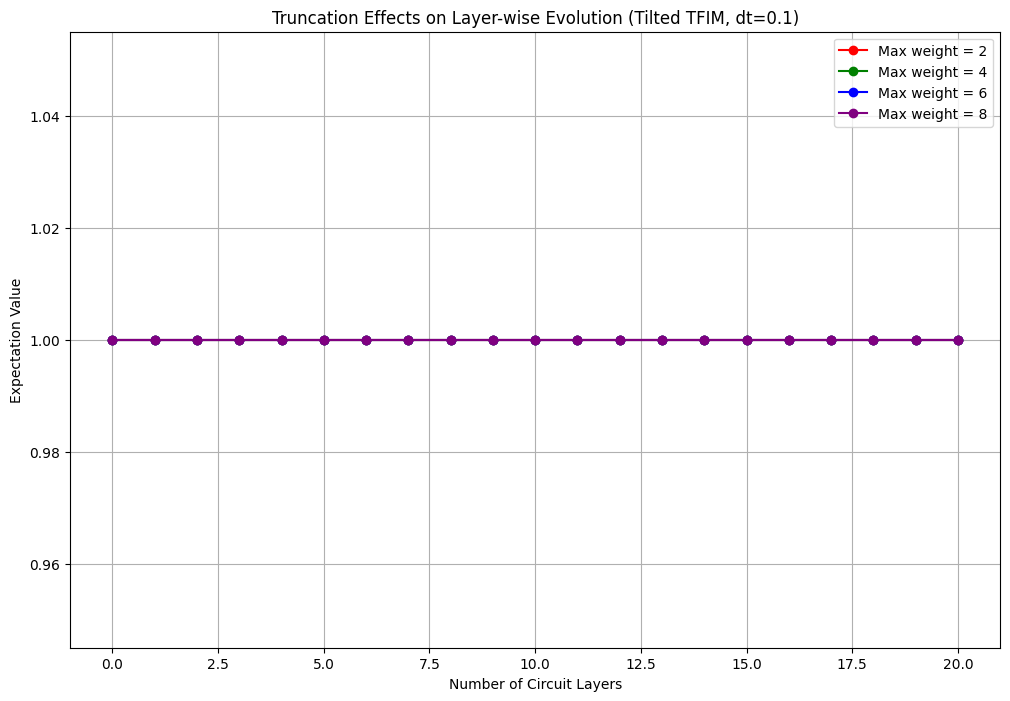

In [15]:
weight_settings = [2, 4, 6, 8]
colors = ['red', 'green', 'blue', 'purple']
dt = 0.1
max_layers = 20

plt.figure(figsize=(12, 8))

for idx, max_w in enumerate(weight_settings):
    psum_trunc = pp.PauliSum(observable)

    expectation_values_trunc = [float(pp.overlapwithzero(psum_trunc))]


    for l in range(1, max_layers + 1):
        pp.propagate(
            single_layer, psum_trunc, layer_params,
            max_weight=max_w, min_abs_coeff=min_abs_coeff
        )
        expectation_values_trunc.append(float(pp.overlapwithzero(psum_trunc)))

    # Print final term count for this truncation
    term_count = jl.length(psum_trunc)
    print(f"Max weight {max_w}: {int(term_count)} Pauli terms after {max_layers} layers")

    # Plot this truncation setting
    plt.plot(layer_indices, expectation_values_trunc, 'o-', color=colors[idx],
             label=f'Max weight = {max_w}')

plt.xlabel('Number of Circuit Layers')
plt.ylabel('Expectation Value')
plt.title(f'Truncation Effects on Layer-wise Evolution (Tilted TFIM, dt={dt})')
plt.legend()
plt.grid(True)
plt.show()